https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

https://docs.gimp.org/en/plug-in-convmatrix.html

In [1]:
# Package imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [79]:
# matrix_1 = np.array([
#     [1, 1, 1, 0, 0],
#     [0, 1, 1, 1, 0],
#     [0, 0, 1, 1, 1],
#     [0, 0, 1, 1, 0],
#     [0, 1, 1, 0, 0]
# ])

matrix_1 = np.array([
    [1, 1, 1, 0, 0, 1],
    [0, 1, 1, 1, 0, 1],
    [0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0],
])

matrix_2 = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 1],
])

filter_sharpen = np.array([[
    [ 0,-1, 0],
    [-1, 5,-1],
    [ 0,-1, 0],
]])

filter_emboss = np.array([[
    [-2,-1, 0],
    [-1, 1, 1],
    [ 0, 1, 2],
]])

edge_detect = np.array([
    [0, 1, 0],
    [1,-4, 1],
    [0, 1, 0],
])


def convolution(matrix, screen, stride):
    
    window_width = matrix.shape[0]
    screen_width = screen.shape[0]
    
    matrix_output = np.zeros(((window_width-2)/2,(window_width-2)/2))
    
    for i in range(0, window_width-2, stride):
        for j in range(0, window_width-2, stride):
            window = matrix[i:i+screen_width,j:j+screen_width]
            combined = screen * window
            matrix_output[i/2][j/2] = combined.sum()

    return matrix_output


In [44]:
pm = 2

# m_3 = matrix_3.shape[0]

# m_4 = m_3 / pm

pooled = np.zeros((2,2))

for i in range(2):
    for j in range(2):
        window = matrix_3[2*i:2*i+2,2*j:2*j+2]
#         print window
        pooled[i][j] = np.sum(window)
        
print pooled



[[ 13.  13.]
 [ 11.   9.]]


In [80]:

def predict_2(X, thetas):
    a = X
    thetas_len = len(thetas)
    for i, theta in enumerate(thetas):
        b = theta[0:1]
        w = theta[1:]
        z = np.dot(a, w) + b

        if i < thetas_len-1:
            a = np.tanh(z)
        else:
            exp_scores = np.exp(z)
            a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
#     print 'a', a
    return np.argmax(a, axis=1)

def calculate_loss_2(X, y, thetas, reg_lambda):
    m = X.shape[0]
    a = X
    thetas_len = len(thetas)

    for i, theta in enumerate(thetas):
        b = theta[0:1]
        w = theta[1:]
        z = np.dot(a, w) + b

        if i < thetas_len-1:
            a = np.tanh(z)
        else:
            exp_scores = np.exp(z)
            a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(a[range(m), y.ravel()])
    data_loss = np.sum(correct_logprobs)
    
    weights_sum = 0
    for theta in thetas:
        w = theta[1:]
        w_sq = np.square(w)
        w_sq_sum = w_sq.sum()
        weights_sum += w_sq_sum
    reg = (reg_lambda/2) * weights_sum
    return 1./m * (data_loss + reg)



def compute_gradient_2(X, y, thetas, reg_lambda):
    m = X.shape[0]
    a = X
    thetas_len = len(thetas)

    activations = [X]
    
    for i, theta in enumerate(thetas):
        b = theta[0:1]
        w = theta[1:]
        z = np.dot(a, w) + b

        if i < thetas_len-1:
            a = np.tanh(z)
        else:
            exp_scores = np.exp(z)
            a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        activations.append(a)

    deltas = [None] * thetas_len
    
    for i in range(thetas_len-1,-1,-1):
        if i == thetas_len-1:
            delta = activations[i+1]
            delta[range(m), y.ravel()] -= 1
        else:
            next_delta = deltas[i+1]
            next_theta = thetas[i+1]
            next_w = next_theta[1:]
            a = activations[i+1]
            delta = np.dot(next_delta, next_w.T) * (1 - np.power(a, 2))
        deltas[i] = delta
    
    thetas_grad = []
    for i in range(len(deltas)):
        delta = deltas[i]
        theta = thetas[i]
        w = theta[1:]
        a = activations[i]
        
        b_grad = np.sum(delta, axis=0, keepdims=True)
        w_grad = np.dot(a.T, delta) + reg_lambda * w
        theta_grad = np.vstack((b_grad, w_grad))
        thetas_grad.append(theta_grad)
    
    return thetas_grad


def gradient_descent(X, y, reg_lambda, alpha, layers, num_iters):    
    
    rand = np.random.RandomState(12)
    
    thetas = []
    for i in range(len(layers)-1):
    
        mm = layers[i]
        nn = layers[i+1]
        theta = rand.rand(mm+1, nn) / np.sqrt(mm)
        theta[0] = 0
        thetas.append(theta)
    
    costs = []
    for i in range(num_iters):
        
        if i % 1 == 0:
            cost = calculate_loss_2(X, y, thetas, reg_lambda)
            costs.append(cost)
        
        thetas_grad = compute_gradient_2(X, y, thetas, reg_lambda)
    
        for i, theta_grad in enumerate(thetas_grad):
            thetas[i] -= alpha * theta_grad

    return thetas, costs


def do_prediction(X, y, thetas):
    m = X.shape[0]
    predicted = predict_2(X, thetas).reshape(m,1)
    n_correct = (predicted == y).sum()
    percent_correct = float(n_correct) / m
    return percent_correct


In [2]:
X = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         54, 227, 253, 252, 239, 233, 252,  57,   6,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,  60,
        224, 252, 253, 252, 202,  84, 252, 253, 122,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 163, 252,
        252, 252, 253, 252, 252,  96, 189, 253, 167,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 238, 253,
        253, 190, 114, 253, 228,  47,  79, 255, 168,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238, 252, 252,
        179,  12,  75, 121,  21,   0,   0, 253, 243,  50,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  38, 165, 253, 233, 208,
         84,   0,   0,   0,   0,   0,   0, 253, 252, 165,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7, 178, 252, 240,  71,  19,
         28,   0,   0,   0,   0,   0,   0, 253, 252, 195,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57, 252, 252,  63,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 252, 195,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 198, 253, 190,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 255, 253, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  76, 246, 252, 112,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 252, 148,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 230,  25,   0,   0,   0,
          0,   0,   0,   0,   0,   7, 135, 253, 186,  12,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 223,   0,   0,   0,   0,
          0,   0,   0,   0,   7, 131, 252, 225,  71,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 145,   0,   0,   0,   0,
          0,   0,   0,  48, 165, 252, 173,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  86, 253, 225,   0,   0,   0,   0,
          0,   0, 114, 238, 253, 162,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 249, 146,  48,  29,  85,
        178, 225, 253, 223, 167,  56,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 252, 252, 229, 215, 252,
        252, 252, 196, 130,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  28, 199, 252, 252, 253, 252, 252,
        233, 145,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  25, 128, 252, 253, 252, 141,
         37,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])



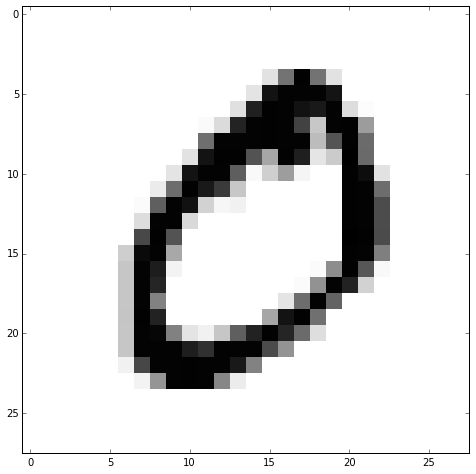

In [54]:
plt.imshow(np.reshape(X, [28,28]), cmap='Greys', interpolation='nearest')

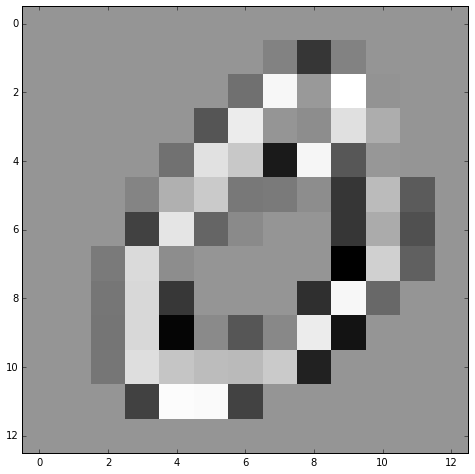

In [12]:
conv_sharp = convolution(np.reshape(X, [28, 28]), filter_sharpen, 2)
plt.imshow(conv_edge, cmap='Greys', interpolation='nearest')

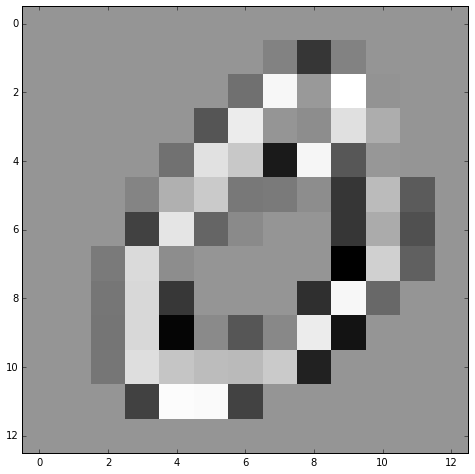

In [11]:
conv_edge = convolution(np.reshape(X, [28, 28]), edge_detect, 2)
plt.imshow(conv_edge, cmap='Greys', interpolation='nearest')

(6, 6)


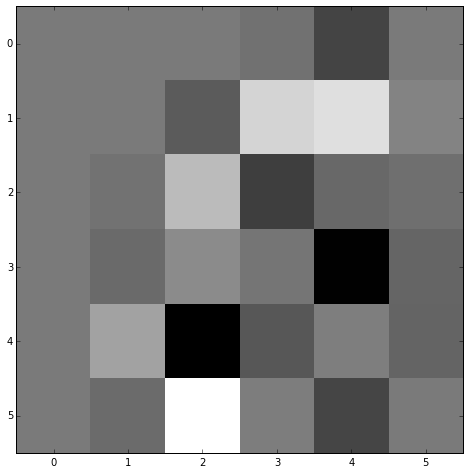

In [13]:
# print conv_edge.shape[0]/2

def pooling(original_matrix, pool_size, method):
    m = original_matrix.shape[0]
    
    num_of_stride = m / pool_size
    
    pool_matrix = np.zeros((num_of_stride, num_of_stride))
    for i in range(num_of_stride):
        i1 = i * pool_size
        i2 = i * pool_size + pool_size
        for j in range(num_of_stride):
            j1 = j * pool_size
            j2 = j * pool_size + pool_size
            
            pool = original_matrix[i1:i2,j1:j2]
            pool_matrix[i][j] = method(pool)
    return pool_matrix

pool_matrix = pooling(conv_edge, 2, np.sum)
print pool_matrix.shape
plt.imshow(pool_matrix, cmap='Greys', interpolation='nearest')


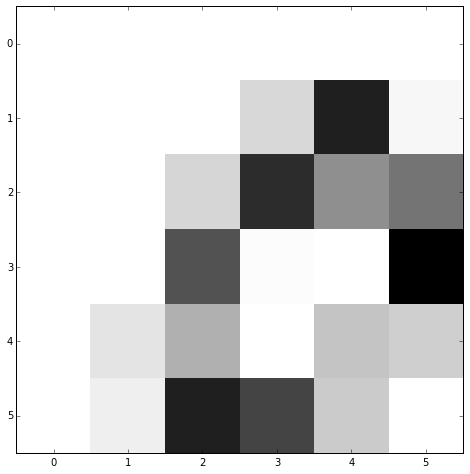

In [14]:
pool_sharp = pooling(conv_sharp, 2, np.sum)
plt.imshow(pool_sharp, cmap='Greys', interpolation='nearest')

In [3]:
df = pd.read_csv('../mnist/mnist_train.csv')

In [37]:

def feature_normalize(X):
    mean = np.mean(X)
    std = np.std(X, ddof=1)
    return ( X - mean ) / std

matrix = df.as_matrix()[:5000]
m = matrix.shape[0]
y = matrix[:,0:1]
X = matrix[:,1:]

X = feature_normalize(X)


NameError: name 'df' is not defined

In [290]:
m = X.shape[0]
conv_1 = np.empty((m,108), dtype=np.float64)
for i, x in enumerate(X):
    convoluted_1 = convolution(np.reshape(x, [28, 28]), filter_sharpen, 2)
    relu_1 = np.maximum(convoluted_1, 0)
    pool_1 = pooling(relu_1, 2, np.sum)
    
    convoluted_2 = convolution(np.reshape(x, [28, 28]), edge_detect, 2)
    relu_2 = np.maximum(convoluted_2, 0)
    pool_2 = pooling(relu_2, 2, np.sum)
    
    convoluted_3 = convolution(np.reshape(x, [28, 28]), filter_emboss, 2)
    relu_3 = np.maximum(convoluted_3, 0)
    pool_3 = pooling(relu_3, 2, np.sum)

    concatenated = np.concatenate((pool_1, pool_2, pool_3), axis=1).reshape(108)
    conv_1[i] = concatenated

print conv_1.shape

(5000, 108)


In [7]:
alpha = 0.0003
reg_lambda = 0.001

layers = [108,12,8,10]
num_iters = 5000

thetas, costs = gradient_descent(conv_1, y, reg_lambda, alpha, layers, num_iters)

print do_prediction(conv_1, y, thetas)
    
plt.plot(costs)


NameError: name 'conv_1' is not defined

In [69]:
layers = [784,12,8,10]
num_iters = 5000

thetas, costs = gradient_descent(X, y, reg_lambda, alpha, layers, num_iters)
print do_prediction(X, y, thetas)


NameError: name 'y' is not defined

In [5]:
X_use = X.copy()
# print X_use.shape
rand = np.random.RandomState(12)
X_norm = feature_normalize(X_use)
# print X_norm
X_conv = convolution(X_norm, filter_sharpen, 2)
X_pool = pooling(X_conv, 2, np.max)
X_pooled = np.reshape(X_pool, [1, 36])

# print X_pool.shape
w1 = 0.5 * rand.rand(36, 8)
b1 = 0.5 * rand.rand(1, 8)
w2 = 0.5 * rand.rand(8, 2)
b2 = 0.5 * rand.rand(1, 2)
# forward propagation
z1 = np.dot(X_pooled, w1) + b1
a1 = np.max(z1, 0)

# softmax
z2 = np.dot(a1, w2) + b2
# print z
a2 = np.exp(z2) / np.sum(np.exp(z2), axis=1)

    
#     for i in range(thetas_len-1,-1,-1):
#         if i == thetas_len-1:
#             delta = activations[i+1]
#             delta[range(m), y.ravel()] -= 1
#         else:
#             next_delta = deltas[i+1]
#             next_theta = thetas[i+1]
#             next_w = next_theta[1:]
#             a = activations[i+1]
#             delta = np.dot(next_delta, next_w.T) * (1 - np.power(a, 2))
#         deltas[i] = delta
    
y_use = np.array([[1]])

print a2

delta2 = a2
print delta2
delta2[[0], [y_use.ravel()]] -= 1
print delta2

print a2
delta1 = np.dot(delta2, w2.T) * (1 - np.power(a1, 2))


# print delta1

# print a1
# print a2




NameError: name 'X' is not defined

In [3]:
print('aaa')

aaa


In [4]:
X

NameError: name 'X' is not defined

In [21]:

def feature_normalize(X):
    mean = np.mean(X)
    std = np.std(X, ddof=1)
    return ( X - mean ) / std

XX = np.array([
        [0.1, 0.9],
        [0.2, 0.8],
        [0.5, 0.5]
    ])

XX = feature_normalize(XX)

yy = np.array([
        [1],
        [1],
    ])

print XX
print np.exp(XX)
probs = np.exp(XX) / np.sum(np.exp(XX), axis=1, keepdims=True)
print probs

print -np.log(probs)


[[-1.26491106  1.26491106]
 [-0.9486833   0.9486833 ]
 [ 0.          0.        ]]
[[ 0.2822644   3.54277764]
 [ 0.38725058  2.58230729]
 [ 1.          1.        ]]
[[ 0.0737938   0.9262062 ]
 [ 0.13040681  0.86959319]
 [ 0.5         0.5       ]]
[[ 2.60648052  0.07665839]
 [ 2.03709638  0.13972978]
 [ 0.69314718  0.69314718]]


In [ ]:

# f(x,y,z) = (x+y)z

# set some inputs
x = -2
y = 5
z = -4

# perform the forward pass
q = x + y # q becomes 3
f = q * z # f becomes -12

# perform the backward pass in reverse order:
# first backprop through f = q * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = z # df/dq = z, so gradient on q becomes -4

# now backprop through q = x + y
dfdx = 1.0 * dfdq # dq/dx = 1. Add the multiplication here is the chain rule
dfdy = 1.0 * dfdy # dq/dy = 1





In [74]:


w0 =  2
x0 = -1
w1 = -3
x1 = -2
w2 = -3

wx0 = w0 * x0
print 'wx0', wx0

wx1 = w1 * x1
print 'wx1', wx1

wx01 = wx0 + wx1
print 'wx01', wx01

z = wx01 + w2
print 'z', z

z_ = z * -1
print 'z_', z_

z__ = np.exp(z_)
print 'z__', z__

z___ = z__ + 1
print 'z___', z___

z____ = 1/z___
print 'z____', z____

dz____ = 1
print 'dz____', dz____

dz___ = -1/ (z___ ** 2)
print 'dz___', dz___

dz__ = (1) * dz___
print 'dz__', dz__

dz_ = np.exp(z_) * dz__
print 'dz_', dz_


wx0 -2
wx1 6
wx01 4
z 1
z_ -1
z__ 0.367879441171
z___ 1.36787944117
z____ 0.73105857863
dz____ 1
dz___ -0.534446645389
dz__ -0.534446645389
dz_ -0.196611933241


In [70]:
x = 3 # example values
y = -4

# forward pass
sigy = 1.0 / (1 + np.exp(-y)) # sigmoid in numerator     #(1)
num = x + sigy # numerator                               #(2)
sigx = 1.0 / (1 + np.exp(-x)) # sigmoid in denominator   #(3)
xpy = x + y                                              #(4)
xpysqr = xpy**2                                          #(5)
den = sigx + xpysqr # denominator                        #(6)
invden = 1.0 / den                                       #(7)
f = num * invden # done!                                 #(8)


In [ ]:

# backprop f = num * invden
dnum = invden # gradient on numerator                    #(8)
dinvden = num                                            #(8)

# backprop invden = 1.0 / den
dden = (-1.0 / (den**2)) * dinvden                       #(7)

# backprop den = sigx + zpysqr
dsigx = (1) * dden                                       #(6)
dxpysqr = (1) * dden                                     #(6)

# backprop xpysqr = zpy**2
dxpy = (2 * xpy) * dxpysqr                               #(5)

# backprop xpy = x + y
dx = (1) * dxpy                                          #(4)
dy = (1) * dxpy                                          #(4)

# backprop sigx = 1.0 / (1 + math.exp(-x))
dx += ((1 - sigx) * sigx) * dsigx                        #(3)

# backprop num = x + sigy
dx += (1) * dnum                                         #(2)
dsigy = (1) * dnum                                       #(2)

# backprop sigy = 1.0 / (1 + np.exp(-y))
dy += ((1 - sigy) * sigy) * dsigy                        #(1)



In [ ]:

x = 3
y = -4

sigy = 1.0 / (1 + np.exp(-y))
num = x + sigy
sigx = 1.0 / (1 + np.exp(-x))
xpy = x + y
xpysqr = xpy ** 2
den = sigx + xpysqr
invden = 1.0 / den
f = num * invden


# f = num * invden
dnum = invden
dinvden = num

# invden = 1.0 / den
dden = (-1.0 / (den ** 2)) * dinvden

# den = sigx + xpysqr
dsigx = (1) * dden
dxpysqr = (1) * dden

# xpysqr = xpy ** 2
dxpy = (2 * xpy) * dxpysqr

# xpy = x + y
dx = (1) * dxpy
dy = (1) * dxpy

# sigx = 1.0 / (1 + np.exp(-x))
dx += ((1 - sigx) * sigx) * dsigx

# num = x + sigy
dx += (1) * dnum
dsigy = (1) * dnum

# sigy = 1.0 / (1 + np.exp(-y))
dy += ((1 - sigy) * sigy) * dsigy
















In [5]:

rand = np.random.RandomState(12)

X_copy = feature_normalize(X)

we = rand.rand(3,3)
rand_grad = rand.rand(13,13)

conv_truth = convolution(np.reshape(X_copy, [28, 28]), we, 2)

conv_pred = conv_truth + rand_grad

# print conv_edge
# print rand_grad
plt.imshow(conv_truth, cmap='Greys', interpolation='nearest')

# print we


NameError: name 'feature_normalize' is not defined

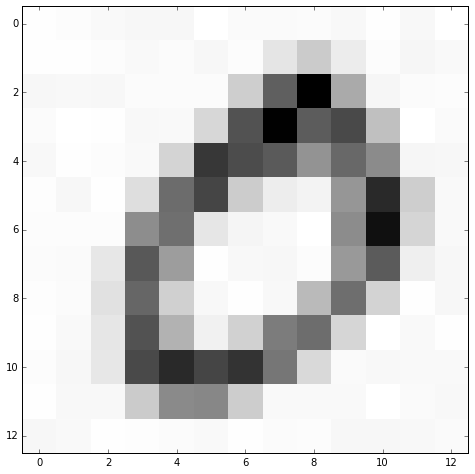

In [107]:
plt.imshow(conv_pred, cmap='Greys', interpolation='nearest')

In [111]:

print X_copy[0]

print we

print convolution(np.reshape(X_copy, [28, 28]), we, 2)[0]

print conv_truth[0]

print conv_pred[0]


[-0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005
 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005
 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005
 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005 -0.47250005
 -0.47250005 -0.47250005 -0.47250005 -0.47250005]
[[ 0.15416284  0.7400497   0.26331502]
 [ 0.53373939  0.01457496  0.91874701]
 [ 0.90071485  0.03342143  0.95694934]]
[-2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647
 -2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647
 -2.13365647]
[-2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647
 -2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647 -2.13365647
 -2.13365647]
[-1.99644715 -1.84982811 -1.52757328 -1.18943133 -1.28092093 -2.13139723
 -1.61243044 -1.58161883 -1.64827905 -1.36552231 -1.97293971 -1.36909602
 -2.11284667]


In [4]:

# def convolution(matrix, screen, stride):
#     window_width = matrix.shape[0]
#     screen_width = screen.shape[0]
#     matrix_output = np.zeros(((window_width-2)/2,(window_width-2)/2))
#     for i in range(0, window_width-2, stride):
#         for j in range(0, window_width-2, stride):
#             window = matrix[i:i+screen_width,j:j+screen_width]
#             combined = screen * window
#             matrix_output[i/2][j/2] = combined.sum()
#     return matrix_output

# print conv_truth[0]
# print conv_pred[0]

r1 = rand.rand(3,3)
r2 = rand.rand(3,3)

r3 = r1 * r2

print r1
print r3 / r2

NameError: name 'rand' is not defined

In [3]:
np.mean(r2)
z = np.ndarray(shape=(3,3))
z.fill(np.mean(r2))
# z

matrix_output = np.zeros((28,28))
for i in range(10):
    for j in range(10):
        
        i_s = i * 2
        i_e = i_s + 3
        
        j_s = j * 2
        j_e = j_s + 3
        
        print 'i', i_s, i_e
        print 'j', j_s, j_e
        
#         matrix_output[2:5,0:3] = r1
        print matrix_output[i:i_e,j_s:j_e].shape
        matrix_output[i:i_e,j_s:j_e] = r1
#         print conv_pred
        
print matrix_output

NameError: name 'r2' is not defined

In [159]:
matrix_output[2:5,2:5] = r1
print matrix_output[2:5,2:5]

[[ 0.33356116  0.10642466  0.18614562]
 [ 0.5192488   0.11262228  0.48392559]
 [ 0.93148838  0.39885519  0.18039198]]


TypeError: 'mtrand.RandomState' object is not callable